In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
!pip install category_encoders
import category_encoders as ce
!pip install keras
import keras
from keras import layers
!pip install keras-tuner -q
import keras_tuner
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler as sc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
!pip install imblearn
import imblearn
from imblearn.over_sampling import SMOTENC, RandomOverSampler

2024-03-18 16:23:12.859781: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 16:23:12.860538: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-18 16:23:12.865196: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-18 16:23:12.931881: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 16:23:13.955719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
seed = 42
epochs = 10

df = pd.read_csv("https://minio.lab.sspcloud.fr/jbrablx/ai_insurance/raw/train.csv")
df.head(10)

df['Vehicle_Damage'] = np.where(df['Vehicle_Damage']!= 'Yes', 1, 0)
df['Gender'] = np.where(df['Gender']!= 'Male', 1, 0)
cats = ['< 1 Year', '1-2 Year', '> 2 Years']
df['Vehicle_Age'] = pd.Categorical(df['Vehicle_Age'],ordered=True, categories=cats)

x = df.drop(['Response', 'id'], axis=1)
y = df[['Response']]

encoder = ce.OrdinalEncoder(cols=['Vehicle_Age'])
x = encoder.fit_transform(x)

#y = np.reshape(y, y.size)
 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=seed)

scaler=sc()
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)

In [3]:
method = "WEIGHTS"
if method == "SMOTE":
    print("SMOTE")
    print("--------")
    cat_features = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Vehicle_Age']
    smote = SMOTENC(random_state=seed, k_neighbors=15, categorical_features=cat_features)
    x_train, y_train = smote.fit_resample(x_train, y_train)

elif method == "OVER":
    print("RandomOverSampler")
    print("--------")
    rs = RandomOverSampler(random_state=seed)
    x_train, y_train = rs.fit_resample(x_train, y_train)

elif method == "WEIGHTS" :
    print("CLASSWEIGHTS")
    print("--------")
    neg, pos = np.bincount(np.reshape(y_train, y_train.size))
    # Scaling by total/2 helps keep the loss to a similar magnitude.
    # The sum of the weights of all stays the same.
    weight_for_0 = (1 / neg)*(neg+pos)/2.0 
    weight_for_1 = (1 / pos)*(neg+pos)/2.0
    class_weights = {0: weight_for_0, 1: weight_for_1}
    print('Weight for class 0: {:.2f}\n'.format(weight_for_0),
          'Weight for class 1: {:.2f}'.format(weight_for_1))
else:
    class_weights = None

CLASSWEIGHTS
--------
Weight for class 0: 0.57
 Weight for class 1: 4.08


In [4]:
x_val, x_train, y_val, y_train = train_test_split(x_train, y_train, test_size=0.8, stratify=y_train, random_state=seed)

x_val_train, x_val_test, y_val_train, y_val_test = train_test_split(x_val, y_val, test_size=0.2, stratify=y_val, random_state=seed)


### Determining the best hyperparameters for the first neural network

In [5]:
def call_existing_code_1(units, dropout, lr):
    model = keras.Sequential()
    model.add(layers.Dense(units=units, activation='relu', input_dim = 10))
    if dropout:
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["f1_score"],
    )
    return model

def build_model_1(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = call_existing_code_1(
        units=units, dropout=dropout, lr=lr
    )
    return model


build_model_1(keras_tuner.HyperParameters())

/opt/mamba/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential, built=True>

In [6]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model_1,
    objective="f1_score",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir_1",
    project_name="helloworld_1",
)

tuner.search_space_summary()

tuner.search(x_val_train, y_val_train, epochs=epochs, batch_size = 100, validation_data=(x_val_test, y_val_test))

tuner.results_summary()

best_hps = tuner.get_best_hyperparameters(5)
model_1 = build_model_1(best_hps[0])


Trial 10 Complete [00h 00m 23s]
f1_score: 0.21837104856967926

Best f1_score So Far: 0.21837104856967926
Total elapsed time: 00h 04m 44s
Results summary
Results in my_dir_1/helloworld_1
Showing 10 best trials
Objective(name="f1_score", direction="min")

Trial 00 summary
Hyperparameters:
units: 256
dropout: True
lr: 0.00023669525078715348
Score: 0.21837104856967926

Trial 01 summary
Hyperparameters:
units: 512
dropout: False
lr: 0.0025510751612212845
Score: 0.21837104856967926

Trial 02 summary
Hyperparameters:
units: 384
dropout: True
lr: 0.0010988954047943937
Score: 0.21837104856967926

Trial 03 summary
Hyperparameters:
units: 352
dropout: False
lr: 0.004545416702014981
Score: 0.21837104856967926

Trial 04 summary
Hyperparameters:
units: 256
dropout: True
lr: 0.0012663755014812239
Score: 0.21837104856967926

Trial 05 summary
Hyperparameters:
units: 192
dropout: False
lr: 0.0025783877510808387
Score: 0.21837104856967926

Trial 06 summary
Hyperparameters:
units: 384
dropout: False
lr: 0

In [8]:
def call_existing_code_2(units_1, units_2, units_3, lr):
    model = keras.Sequential()
    model.add(keras.Input(shape=(10,)))
    model.add(keras.layers.Dense(units_1, activation='relu')) #Adds a dense layer with 128 neurons and a ReLU activation function.
    model.add(keras.layers.Dense(units_2, activation='relu')) #Adds a second dense layer with 128 neurons and a ReLU activation function.
    model.add(keras.layers.Dense(units_3, activation='relu')) #Adds a third dense layer with 32 neurons and a ReLU activation function.
    model.add(keras.layers.Dense(1, activation='sigmoid')) #Add an output layer with 1 neuron and a sigmoid activation function.
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=lr), 
        loss=keras.losses.BinaryCrossentropy(), 
        metrics=['f1_score'])
    return model

def build_model_2(hp):
    units_1 = hp.Int("units", min_value=32, max_value=512, step=32)
    units_2 = hp.Int("units", min_value=32, max_value=512, step=32)
    units_3 = hp.Int("units", min_value=32, max_value=512, step=32)
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = call_existing_code_2(
        units_1=units_1, units_2=units_2, units_3=units_3, lr=lr
    )
    return model


build_model_2(keras_tuner.HyperParameters())


<Sequential name=sequential_2, built=True>

In [9]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model_2,
    objective="f1_score",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir_2",
    project_name="helloworld_2",
)

tuner.search_space_summary()

tuner.search(x_val_train, y_val_train, epochs=epochs, batch_size = 100, validation_data=(x_val_test, y_val_test))

tuner.results_summary()

best_hps = tuner.get_best_hyperparameters(5)
model_2 = build_model_2(best_hps[0])

Trial 10 Complete [00h 01m 11s]
f1_score: 0.21837104856967926

Best f1_score So Far: 0.21837104856967926
Total elapsed time: 00h 07m 25s
Results summary
Results in my_dir_2/helloworld_2
Showing 10 best trials
Objective(name="f1_score", direction="min")

Trial 00 summary
Hyperparameters:
units: 128
lr: 0.00038747292328016573
Score: 0.21837104856967926

Trial 01 summary
Hyperparameters:
units: 416
lr: 0.000723051095080521
Score: 0.21837104856967926

Trial 02 summary
Hyperparameters:
units: 32
lr: 0.0013203367674065015
Score: 0.21837104856967926

Trial 03 summary
Hyperparameters:
units: 32
lr: 0.00014639201336952797
Score: 0.21837104856967926

Trial 04 summary
Hyperparameters:
units: 128
lr: 0.004806489177337456
Score: 0.21837104856967926

Trial 05 summary
Hyperparameters:
units: 416
lr: 0.002770285640257412
Score: 0.21837104856967926

Trial 06 summary
Hyperparameters:
units: 160
lr: 0.00359800375100564
Score: 0.21837104856967926

Trial 07 summary
Hyperparameters:
units: 96
lr: 0.00019601

### Cross-Validation

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,561 (135.00 KB)

 Trainable params: 34,561 (135.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.2164 - loss: 0.6890
Epoch 2/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - f1_score: 0.2196 - loss: 0.6534
Epoch 3/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2178 - loss: 0.6110
Epoch 4/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2168 - loss: 0.5697
Epoch 5/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2189 - loss: 0.5346
Epoch 6/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2179 - loss: 0.5045
Epoch 7/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2185 - loss: 0.4851
Epoch 8/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2172 - loss: 0.4718
Epoch 9/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2199 - loss: 0.4645
Epoch 10/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2176 - loss: 0.4576
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - f1_score: 0.2195 - loss: 0.4996


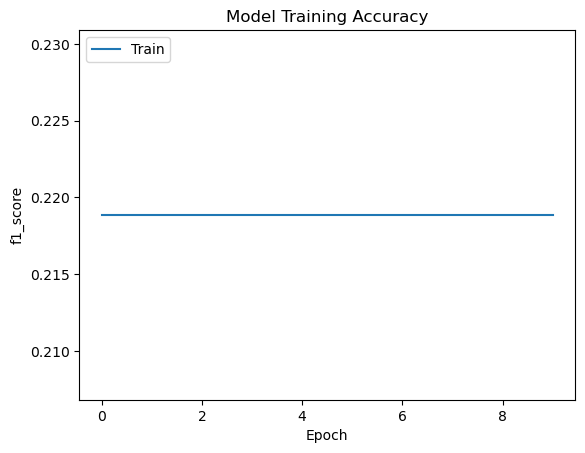

Epoch 1/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2187 - loss: 0.4524
Epoch 2/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2196 - loss: 0.4499
Epoch 3/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2198 - loss: 0.4471
Epoch 4/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.2182 - loss: 0.4393
Epoch 5/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2192 - loss: 0.4412
Epoch 6/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2165 - loss: 0.4388
Epoch 7/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2179 - loss: 0.4403
Epoch 8/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2189 - loss: 0.4384
Epoch 9/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2182 - loss: 0.4366
Epoch 10/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2191 - loss: 0.4358
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - f1_score: 0.2219 - loss: 0.4784


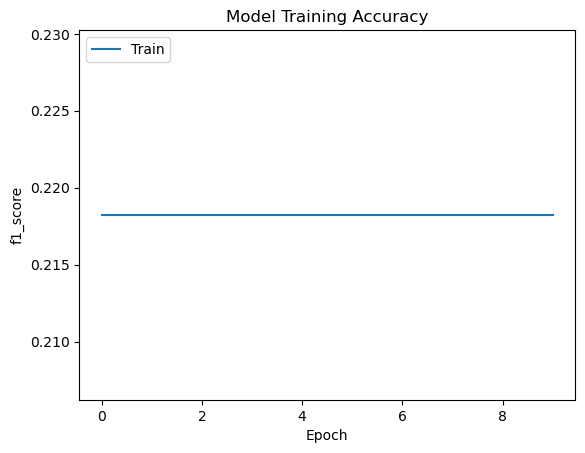

Epoch 1/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2174 - loss: 0.4366
Epoch 2/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2177 - loss: 0.4366
Epoch 3/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2190 - loss: 0.4387
Epoch 4/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2199 - loss: 0.4390
Epoch 5/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2197 - loss: 0.4365
Epoch 6/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2185 - loss: 0.4355
Epoch 7/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2178 - loss: 0.4346
Epoch 8/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2186 - loss: 0.4352
Epoch 9/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2182 - loss: 0.4352
Epoch 10/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2167 - loss: 0.4337
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - f1_score: 0.2178 - loss: 0.4810


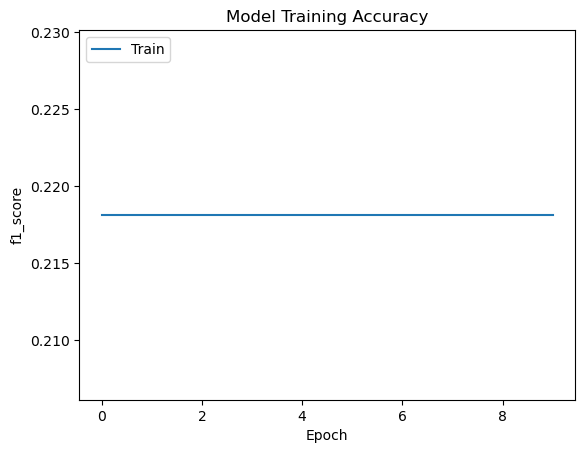

Epoch 1/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2215 - loss: 0.4354
Epoch 2/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2186 - loss: 0.4340
Epoch 3/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2184 - loss: 0.4339
Epoch 4/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2178 - loss: 0.4333
Epoch 5/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2176 - loss: 0.4339
Epoch 6/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2180 - loss: 0.4320
Epoch 7/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2187 - loss: 0.4351
Epoch 8/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2192 - loss: 0.4325
Epoch 9/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2190 - loss: 0.4336
Epoch 10/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2180 - loss: 0.4336
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - f1_score: 0.2161 - loss: 0.4800


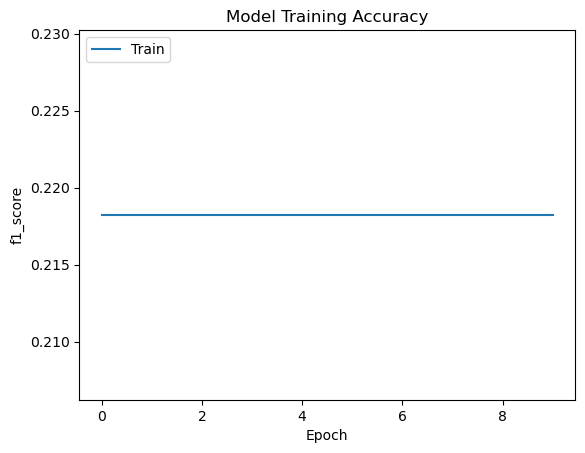

Mean f1_score: 0.218 +/- 0.001


In [12]:
#x_train = x_train.to_numpy()
#y_train = y_train.to_numpy()

model = model_2

kfold = KFold(n_splits = 4, shuffle=True, random_state=seed)

# Initialize a list to store the scores
scores = []

model.summary()

for train_index, test_index in kfold.split(x_train,y_train):
    # Split the data into train and test sets
    Y_train, Y_test = y_train[train_index], y_train[test_index]
    X_train, X_test = x_train[train_index], x_train[test_index]

    # Fit the model on the training data
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=100, class_weight = class_weights)

    # Evaluate the model on the test data
    score = model.evaluate(X_test, Y_test)

    # Append the score to the scores list
    scores.append(score[1])
    plt.plot(history.history['f1_score'])
    plt.title('Model Training Accuracy')
    plt.ylabel('f1_score')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()
  
# Print the mean and standard deviation of the scores
print(f'Mean f1_score: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

### Fit

Epoch 1/10
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.2177 - loss: 0.4310 - val_f1_score: 0.2184 - val_loss: 0.4800
Epoch 2/10
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.2184 - loss: 0.4320 - val_f1_score: 0.2184 - val_loss: 0.4756
Epoch 3/10
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.2206 - loss: 0.4342 - val_f1_score: 0.2184 - val_loss: 0.4777
Epoch 4/10
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - f1_score: 0.2187 - loss: 0.4343 - val_f1_score: 0.2184 - val_loss: 0.4826
Epoch 5/10
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.2166 - loss: 0.4298 - val_f1_score: 0.2184 - val_loss: 0.4821
Epoch 6/10
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.2179 - loss: 0.4320 - val_f1_score: 0.2184 - val_loss: 0.4788
Epoch 7/10
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.2178 - loss: 0.4317 - val_f1_score: 0.2184 - val_loss: 0.4795
Epoch 8/10
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - f1_score: 0.2178 - loss: 0.4318 - 

[]

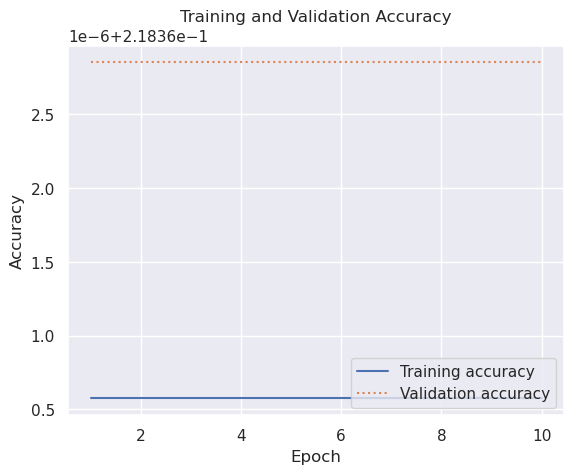

In [14]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=100, class_weight = class_weights)

#F1 Score
sns.set()
acc = hist.history['f1_score']
val = hist.history['val_f1_score']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


Text(109.44999999999997, 0.5, 'Actual label')

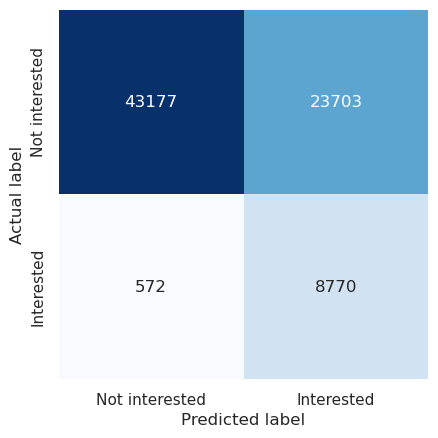

In [15]:
#Confusion Matrix
y_predicted = model.predict(x_test) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['Not interested', 'Interested']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')